<a href="https://colab.research.google.com/github/Afes4/Taller-cuadernos/blob/main/Cuaderno_Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Procesamiento Paralelo. Mejores prácticas**

# **Mejores prácticas con *dask.delayed***

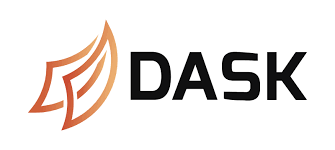

# **Autor**

Anderson Felipe Estrada Sánchez, anestradas@unal.edu.co

# **Tomado de:**

https://github.com/AprendizajeProfundo/BigData/blob/main/Dask/Cuadernos/01_dask_Mejores_Practicas.ipynb

https://github.com/dask/dask-tutorial

https://docs.dask.org/en/stable/delayed-best-practices.html

# **Introducción**

Es fácil comenzar con Dask delayed, pero usarlo bien requiere algo de experiencia. Esta lección contiene sugerencias de mejores prácticas e incluye soluciones a problemas comunes.

In [ ]:
!python -m pip install "dask[complete]"
import dask
import dask.dataframe as dd

     |████████████████████████████████| 136 kB 3.1 MB/s 
     |████████████████████████████████| 837 kB 29.8 MB/s 
     |████████████████████████████████| 830 kB 47.1 MB/s 
     |████████████████████████████████| 822 kB 51.5 MB/s 
     |████████████████████████████████| 802 kB 52.7 MB/s 
     |████████████████████████████████| 802 kB 49.1 MB/s 
     |████████████████████████████████| 793 kB 36.6 MB/s 
     |████████████████████████████████| 793 kB 45.1 MB/s 
     |████████████████████████████████| 791 kB 45.6 MB/s 
     |████████████████████████████████| 786 kB 43.7 MB/s 
     |████████████████████████████████| 779 kB 48.1 MB/s 
     |████████████████████████████████| 778 kB 13.8 MB/s 
     |████████████████████████████████| 776 kB 43.5 MB/s 
     |████████████████████████████████| 769 kB 43.6 MB/s 
     |████████████████████████████████| 766 kB 43.2 MB/s 
     |████████████████████████████████| 1.0 MB 48.1 MB/s 
     |████████████████████████████████| 722 kB 52.3 MB/s 
     |█████████

In [ ]:
from dask.delayed import delayed

# **Llamada retrasada a la función, no al resultado**

Dask delayed opera en funciones como ***dask.delayed(f)(x, y)***, no en sus resultados como ***dask.delayed(f(x, y))***. Cuando haces esto último, Python primero calcula ***f(x, y)*** antes de que Dask tenga la oportunidad de intervenir.

*   **Forma incorrecta:**

    Esto se ejecuta inmediatamente

        dask.delayed(f(x, y))

*   **Forma correcta:**

    Esto retrasa la función, haciendola actuar "perezosamente"
  
        dask.delayed(f)(x, y)

# **Programe muchos cálculos a la vez**

Para mejorar el paralelismo, debe incluir muchos cálculos en cada "llamada" de compute. Idealmente, debe realizar muchas llamadas ***dask.delayed*** para definir su cálculo y luego llamar unicamente al final, ***dask.compute***. Y aunque, támbien está bien llamar ***dask.compute*** en medio de su cálculo , todo se detendrá allí mientras ***Dask*** calcula esos resultados antes de continuar con su código.



*   **Forma incorrecta:**

    Evite llamar a compute repetidamente

        results = []
        for x in L:
            y = dask.delayed(f)(x)
            results.append(y.compute())

        results

*   **Forma correcta:**
 
    Recopile muchas llamadas para un solo compute

        results = []
        for x in L:
            y = dask.delayed(f)(x)
            results.append(y)

        results = dask.compute(*results)

Llamar ***y.compute()*** dentro del ciclo se esperaría el resultado del cálculo cada vez, y por lo tanto, inhibiría el paralelismo.

# **No modifique las entradas**


*   **Forma incorrecta:**

    Modifique entradas en funciones

        @dask.delayed
        def f(x):
            x += 1
            return x

*   **Forma correcta:**
 
    Devolver nuevos valores o copias

        @dask.delayed
        def f(x):
            x = x + 1
            return x   
*   Si necesita usar una operación modificable, primero haga una copia dentro de su función: 
  
        @dask.delayed
        def f(x):
            x = copy(x)
            x += 1
            return x



# **Evite el estado global**

Idealmente, sus operaciones no deberían depender del estado global. El uso del estado global puede funcionar si solo usa subprocesos, pero cuando se pasa a la computación distribuida o multiprocesamiento, es probable que encuentre errores confusos.


*   **Forma incorrecta:**

        L = []

        # Esto hace referencia a la variable global L

        @dask.delayed
        def f(x):
            L.append(x)


# **Evite efectos colaterales**

Las funciones delayed solo hacen algo si se calculan. Siempre necesitará pasar la salida a algo que eventualmente llame a compute.


*   **Forma incorrecta:**

    Olvídese de llamar a compute

        dask.delayed(f)(1, 2, 3)
        ...

*   **Forma correcta:**
 
    Asegúrese de que las tareas retrasadas se calculen

        x = dask.delayed(f)(1, 2, 3)
        ...
        dask.compute(x, ...)   


En el primer caso aquí, no pasa nada, porque nunca se llama a compute().

# **Divida los cálculos en muchas partes**

Cada llamada a la función ***dask.delayed*** es una sola operación desde la perspectiva de ***Dask***. Usted logra el paralelismo teniendo muchas llamadas retrasadas, no usando solo una: Dask no mirará dentro de una función decorada con ***@dask.delayed*** y paralelizará ese código internamente. Para lograr eso, necesita su ayuda para encontrar buenos lugares para dividir un cálculo.


*   **Forma incorrecta:**

    Una tarea gigante

        def load(filename):
            ...

        def process(data):
            ...

        def save(data):
            ...

        @dask.delayed
        def f(filenames):
            results = []
            for filename in filenames:
                data = load(filename)
                data = process(data)
                result = save(data)

            return results

        dask.compute(f(filenames))

*   **Forma correcta:**
 
    Dividirse en muchas tareas

        @dask.delayed
        def load(filename):
            ...

        @dask.delayed
        def process(data):
            ...

        @dask.delayed
        def save(data):
            ...

        def f(filenames):
            results = []
            for filename in filenames:
                data = load(filename)
                data = process(data)
                result = save(data)

            return results

        dask.compute(f(filenames))  

La primera versión solo tiene una tarea retrasada, por lo que no se puede paralelizar.

# **Evite demasiadas tareas retrasadas**

Cada tarea retrasada tiene una sobrecarga de unos cientos de microsegundos. Por lo general, esto está bien, pero puede convertirse en un problema si aplica ***dask.delayed*** demasiado finamente. En este caso, a menudo es mejor dividir sus muchas tareas en lotes o usar una de las colecciones de Dask para ayudarlo.

*   **Forma incorrecta:**

    Demasiadas tareas

        results = []
        for x in range(10000000):
            y = dask.delayed(f)(x)
            results.append(y)
*   **Forma correcta:**
 
    Usar colecciones

        import dask.bag as db
        b = db.from_sequence(range(10000000), npartitions=1000)
        b = b.map(f)
        ...   


Aquí usamos ***dask.bag*** para aplicar por lotes automáticamente nuestra función. También podríamos haber construido nuestro propio procesamiento por lotes de la siguiente manera:

*   Alternativamente, sin usar bag collection

        def batch(seq):
            sub_results = []
            for x in seq:
                sub_results.append(f(x))
            return sub_results

         batches = []
         for i in range(0, 10000000, 10000):
             result_batch = dask.delayed(batch)(range(i, i + 10000))
             batches.append(result_batch)




Aquí construimos lotes donde cada llamada de función retrasada calcula muchos puntos de datos desde la entrada original.

# **Evite llamar delayed dentro de funciones retrasadas**

A menudo, si es nuevo en el uso de Dask delayed, realiza llamadas ***dask.delayed*** en todas partes y espera lo mejor. Si bien esto puede funcionar, generalmente es lento y da como resultado soluciones difíciles de entender.

Por lo general, nunca llame a ***dask.delayed*** dentro de las funciones ***dask.delayed***.

*   **Forma incorrecta:**

    Evitar: Delayed function calls delayed

        @dask.delayed
        def process_all(L):
            result = []
            for x in L:
                y = dask.delayed(f)(x)
                result.append(y)
            return result

*   **Forma correcta:**
 
    Llamadas de funciones normales retrasadas

        def process_all(L):
            result = []
            for x in L:
                y = dask.delayed(f)(x)
                result.append(y)
            return result  


Debido a que la función normal solo realiza el trabajo retrasado, es muy rápida y, por lo tanto, no hay razón para retrasarla.

# **No llame a dask.delayed en otras colecciones de Dask**

Cuando coloca una matriz Dask o Dask DataFrame en una llamada retrasada, esa función recibirá el equivalente de NumPy o Pandas.

Tenga en cuenta que si su matriz es grande, esto podría bloquear a sus trabajadores.

En cambio, es más común usar métodos como ***da.map_blocks***.

*   **Forma incorrecta:**

    Llamar funciones retrasadas en las colecciones de Dask

        import dask.dataframe as dd
        df = dd.read_csv('/path/to/*.csv')

        dask.delayed(train)(df)

*   **Forma correcta:**
 
    Use métodos de mapeo si corresponde

        import dask.dataframe as dd
        df = dd.read_csv('/path/to/*.csv')

        df.map_partitions(train)

*   Alternativamente, si el procedimiento no encaja en un mapeo, siempre puede convertir sus arreglos o marcos de datos en muchos objetos retrasados, por ejemplo:

        import dask.dataframe as dd
        df = dd.read_csv('/path/to/*.csv')
        
        partitions = df.to_delayed()
        delayed_values = [dask.delayed(train)(part)
                         for part in partitions]

                         

*   Sin embargo, si no le importa convertir su Dask array/DataFrame en un solo fragmento, está bien.

        dask.delayed(train)(..., y=df.sum())




# **Evite poner repetidamente grandes entradas en llamadas retrasadas**

Cada vez que pase un resultado concreto (cualquier cosa que no se retrase), Dask lo codificará de forma predeterminada para darle un nombre. Esto es bastante rápido (alrededor de 500 MB / s) pero puede ser lento si lo hace una y otra vez. En cambio, también es mejor retrasar sus datos.

Esto es especialmente importante cuando se usa un clúster distribuido para evitar enviar sus datos por separado para cada llamada de función.

*   **Forma incorrecta:**

        x = np.array(...)  # Para arrays grandes

        results = [dask.delayed(train)(x, i)
                   for i in range(1000)]

*   **Forma correcta:**
 
        x = np.array(...)    # Para arrays grandes
        x = dask.delayed(x)  # retrasar los datos una vez

        results = [dask.delayed(train)(x, i)
                   for i in range(1000)] 

Cada llamada a ***dask.delayed(train)(x, ...)*** tiene que codificar el array NumPy x, lo que ralentiza las cosas.